# Descobrindo o algoritmo de valorização do Cartola FC - Parte I

## Explorando o algoritmo de valorização do Cartola.

Olá! Este é o primeiro tutorial da série que tentará descobrir o algoritmo de valorização do Cartola FC. Neste primeiro estudo, nós iremos:

1. Avaliar o sistema de valorizção ao longo das rodadas; 
2. Estudar a distribuição a variação para cada rodada; 
3. Realizar um estudo de caso com um jogador específico, estudando sua valorização e criando um modelo específico de valorização para o jogador.

Além disso, você estudará análise de dados usando Python com Pandas, Seaborn, Sklearn. Espero que você tenha noção sobre:

* Modelos lineares
* Análise de séries temporais
* Conhecimentos básicos do Cartola FC.


In [9]:
# Importar bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format

# Abrir banco de dados
dados = pd.read_csv('~/caRtola/data/desafio_valorizacao/valorizacao_cartola_2018.csv')

# Listar nome das variáveis
str(list(dados))

"['n', 'nome_completo', 'slug', 'apelido', 'foto', 'id', 'rodada', 'id_time', 'posicao', 'status', 'pontos', 'preco', 'variacao_preco', 'media_pontos', 'nome_time', 'CA', 'FC', 'FS', 'GC', 'I', 'PE', 'RB', 'SG', 'FF', 'FD', 'G', 'DD', 'GS', 'A', 'FT', 'CV', 'DP', 'PP']"

In [10]:
# Selecionar variáveis para análise
dados = dados[['slug', 'rodada', 'posicao',
               'status', 'variacao_preco', 'pontos',
              'preco', 'media_pontos']]

In [17]:
# Explorar dados de apenas um jogador
paqueta = dados[dados.slug == 'lucas-paqueta']
paqueta.head(n=15)

,slug,rodada,posicao,status,variacao_preco,pontos,preco,media_pontos
21134,lucas-paqueta,38,mei,Provável,-0.74,-1.0,20.15,6.52
21135,lucas-paqueta,37,mei,Provável,0.65,2.9,20.89,6.76
21136,lucas-paqueta,36,mei,Dúvida,0.00,0.0,20.24,6.89
21137,lucas-paqueta,35,mei,Suspenso,-1.52,-3.7,20.24,6.89
21138,lucas-paqueta,34,mei,Provável,0.00,0.0,21.76,7.26
21139,lucas-paqueta,33,mei,Suspenso,0.17,3.4,21.76,7.26
21140,lucas-paqueta,32,mei,Provável,-0.73,2.4,21.59,7.40
21141,lucas-paqueta,31,mei,Provável,-0.61,6.8,22.32,7.59
21142,lucas-paqueta,30,mei,Provável,1.63,11.6,22.93,7.62
21143,lucas-paqueta,29,mei,Provável,-2.04,3.6,21.30,7.46


Algumas observações sobre a estrutura dos dados. Na linha '21136', Paquetá está como dúvida é teve pontuação de 0. Na linha abaixo ('21137'), ele está suspenso, no entanto pontuou. 

A explicação para este erro nos dados está ligada em como os dados da API da Globo são organizados. Embora para o front-end do Cartola os dados estejam corretos, para nossa análise eles são inadequados. Por quê?

Vamos pensar que você está escalando para a rodada 38. Para esta rodada, a pontuação do jogador ainda não está disponível, somente a variação do seu preço, sua média e seu preço _até_ a rodada 38. Assim, precisamos ajustar a coluna 'pontos', usando uma técnica simples de deslocar (lag) os dados da coluna. Além disso, precisaremos aplicar o mesmo processo na coluna 'variacao_preco' que também está ligada aos dados da rodada anterior.

Assim, a coluna 'variacao_preco' e 'pontos' estão deslocadas para cima e precisam ser corrigidas;


In [18]:
# Criar coluna variacao_preco_lag e pontos_lag
paqueta['variacao_preco_lag'] = paqueta['variacao_preco'].shift(1)
paqueta['pontos_lag'] = paqueta['pontos'].shift(1)
paqueta['media_lag'] = paqueta['media_pontos'].shift(-1)

paqueta[['slug', 'rodada', 'status',
         'pontos_lag', 'variacao_preco_lag',
         'preco', 'media_pontos']].head(n=15)

,slug,rodada,status,pontos_lag,variacao_preco_lag,preco,media_pontos
21134,lucas-paqueta,38,Provável,NaN,NaN,20.15,6.52
21135,lucas-paqueta,37,Provável,-1.0,-0.74,20.89,6.76
21136,lucas-paqueta,36,Dúvida,2.9,0.65,20.24,6.89
21137,lucas-paqueta,35,Suspenso,0.0,0.00,20.24,6.89
21138,lucas-paqueta,34,Provável,-3.7,-1.52,21.76,7.26
21139,lucas-paqueta,33,Suspenso,0.0,0.00,21.76,7.26
21140,lucas-paqueta,32,Provável,3.4,0.17,21.59,7.40
21141,lucas-paqueta,31,Provável,2.4,-0.73,22.32,7.59
21142,lucas-paqueta,30,Provável,6.8,-0.61,22.93,7.62
21143,lucas-paqueta,29,Provável,11.6,1.63,21.30,7.46


Como podemos observar na tabela acima, os novos atributos que criamos agora estão alinhados com o status do atleta e poderão nos ajudar na etapa da modelagem. Antes de modelar, vamos explorar ainda nossos dados.

Primeira, observação para entendermos o modelo. O jogador quando está suspenso (linha 21137) ou seu status é nulo, não houve variação de preço. Há também outro ponto a ser observado, caso a pontuação do atleta seja positiva, há uma tendência de valorização. Vamos analisar isso nos dois gráficos abaixo.

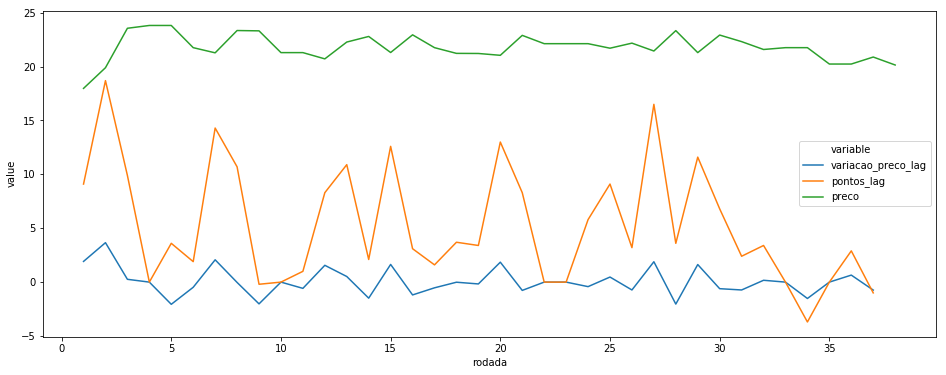

In [5]:
# Transformar dados para plotar resultados
paqueta_plot = pd.melt(paqueta, 
                       id_vars=['slug','rodada'], 
                       value_vars=['variacao_preco_lag', 'pontos_lag', 'preco'])

# Plotar gráfico com variacao_preco_lag, pontos_lag e preco
plt.figure(figsize=(16, 6))
g = sns.lineplot(x='rodada', y='value', hue='variable', data=paqueta_plot)

Neste gráfico, podemos observar que o preço do atleta foi razoavelmente estável ao longo do tempo. Ao observar o comportamento das linhas azul e laranja, conseguimos notar que quando uma linha tem inclinação negativa a outra parece acompanhar. Isso nos leva a concluir o óbvio, a pontuação do atleta está ligada diretamente a sua variação de preço.

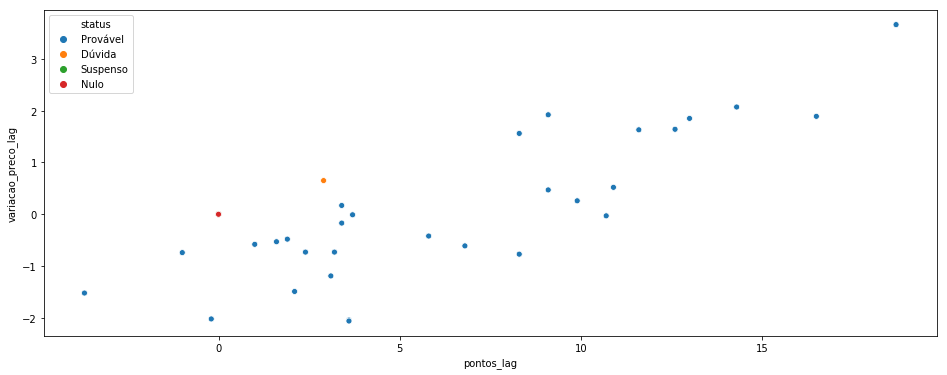

In [6]:
plt.figure(figsize=(16, 6))
g = sns.scatterplot(x='pontos_lag', y='variacao_preco_lag', hue='status', data=paqueta)

Opa, aparentemente há uma relação entre os pontos e a variação do preço. Vamos analisar a matriz de correlação.

In [19]:
paqueta[['pontos_lag','variacao_preco_lag','preco','media_pontos']].corr()

,pontos_lag,variacao_preco_lag,preco,media_pontos
pontos_lag,1.000000,0.757728,-0.216244,0.143046
variacao_preco_lag,0.757728,1.000000,-0.643497,0.047216
preco,-0.216244,-0.643497,1.000000,0.232861
media_pontos,0.143046,0.047216,0.232861,1.000000


Temos algumas informações uteis que saíram da matriz de correlação. Primeira, a pontuação está correlacionada positivamente com a variação e o preço do atleta negativamente correlacionada. Estas duas variáveis já podem nos ajudar a montar um modelo.

In [20]:
# Set predictors and dependent variable
paqueta_complete = paqueta[(~paqueta.status.isin(['Nulo', 'Suspenso'])) & (paqueta.rodada > 5)]
paqueta_complete = paqueta_complete.dropna()

predictors = paqueta_complete[['pontos_lag','preco','media_lag']]
outcome = paqueta_complete['variacao_preco_lag']

regr = linear_model.LinearRegression()
regr.fit(predictors, outcome)
paqueta_complete['predictions'] = regr.predict(paqueta_complete[['pontos_lag', 'preco', 'media_lag']])

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)
print("Mean squared error: %.2f"
      % mean_squared_error(paqueta_complete['variacao_preco_lag'], paqueta_complete['predictions']))
print('Variance score: %.2f' % r2_score(paqueta_complete['variacao_preco_lag'], paqueta_complete['predictions']))

Intercept: 
 15.54265633373975
Coefficients: 
 [ 0.17382942 -0.78670605  0.0765789 ]
Mean squared error: 0.04
Variance score: 0.97


Boa notícia! Nós estamos prevendo os resultados do jogador muito bem. O valor é aproximado, mas nada mal! A fórmula de valorização do jogador para uma dada rodada é:

$$ Variacao = 16.12 + (pontos * 0,174) - (preco * 0,824) + (media * 0,108) $$

Vamos abaixo em que medida nossas predições são compatíveis com o desempenho do jogador.

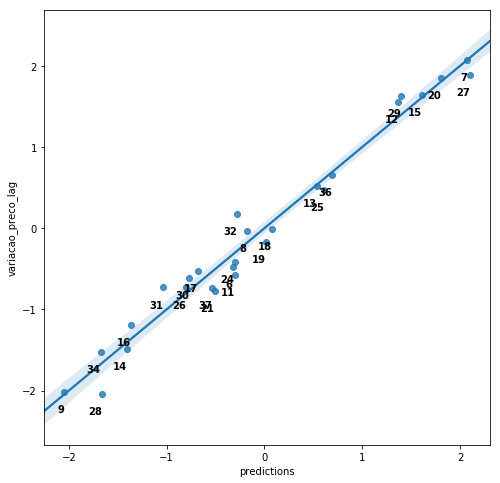

In [9]:
# Plotar variação do preço por valor previsto do modelo linear. 

plt.figure(figsize=(8, 8))
g = sns.regplot(x='predictions',y='variacao_preco_lag', data=paqueta_complete)
# Plotar linhas com rodadas para avaliar se estamos errando alguma rodada específica
for line in range(0, paqueta_complete.shape[0]):
    g.text(paqueta_complete.iloc[line]['predictions'], 
           paqueta_complete.iloc[line]['variacao_preco_lag']-0.25, 
           paqueta_complete.iloc[line]['rodada'], 
           horizontalalignment='right', 
           size='medium', 
           color='black', 
           weight='semibold')

Nossa previsão para o jogador Paquetá estão muito boas. Não descobrimos o algoritmo do Cartola, mas já temos uma aproximação acima do razoável. Será que nosso modelo é generalizável aos outros jogadores?

Acompanhe nossa próxima publicação...